# 개요
이 노트북은 과제3을 위해 BOHB 하이퍼 파라미터 최적화 기법을 사용하여 mnist 데이터셋을 분류하는 DNN을 훈련시키는데 가장 적합한 하이퍼 파라미터를 찾아내는 코드 입니다.

# 주의
이 노트북은 빠른 실행을 위한 Colab의 GPU 설정과 훈련 과정 저장을 위한 Google 드라이브 사용이 포함되어있으므로 실행을 위해 **Google 계정 및 드라이브 연동이 필요합니다**. 또한 실행 중 드라이브 권한 승인을 위한 팝업이 나올 수 있습니다.

# 사용법
1. **학습 실행** 전 까지 코드를 전부 실행합니다. 구글 드라이브 연동 권한에 대한 팝업이 등장하면 승인합니다.

2. **학습 실행** 에서는 **원하는 epoch까지 실행한 뒤, 실행을 종료**시키면 됩니다.(기본으로는 100 epoch까지 실행되어 사실상 끝나지 않습니다. 숫자를 수정하여 특정 epoch에서 종료시킬 수 있습니다.)

3. 이후 분석을 위한 코드를 실행시킵니다.

학습 실행을 하지 않더라도 **1.** 과정만 진행한 뒤, 드라이브에 생성된 "/content/drive/My Drive/HW3_results"폴더에 첨부된 pkl 파일을 넣으면 과제에 사용된 통계를 다시 확인할 수 있습니다.

# GPU 사용

코랩의 GPU 사용을 위한 설정입니다

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# 라이브러리 설치

BOHB를 위한 라이브러리는 Colab에 기본으로 설치되어 있지 않기 때문에 별도로 설치합니다.

In [ ]:
!pip install hpbandster
!pip install ConfigSpace

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 27.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for hpbandster: filename=hpbandster-0.7.4-py3-none-any.whl size=79991 sha256=ac593e298709175653e9d896e183e5d399208fd5238a8e0a769f0b4df50f694b
  Stored in directory: /root/.cache/pip/wheels/79/51/18/33d6ba8c55cc8401bffbccb1b87b21e0c68f40edc4ce3c1f99
  Created wheel for netifaces: filename=netifaces-0.11.0-cp310-cp310-linux_x86_64.whl size=35007 sha256=c08c652e8428d627ef11df46c898e0d0ba4baaa4c183b46c5e4a9e7e7d8a50b0
  Stored in directory: /root/.cache/pip/wheels/48/65/b3/4c4cc6038b81ff21cc9df69f2b6774f5f52e23d3c275ed15aa
Successfully built hpbandster netifaces


# 전처리(데이터 다운로드 및 나누기)

간단한 전처리입니다.

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# 데이터셋 로드
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 데이터 전처리
x_train = x_train.reshape(-1, 28*28).astype('float32') / 255.0
x_test = x_test.reshape(-1, 28*28).astype('float32') / 255.0
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# 2.4. train data를 4:1로 분할하여 validation data 생성
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)


11490434/11490434 [==============================] - 0s 0us/step


# 데이터 증강

과적합을 방지하기 위한 데이터 증강입니다.

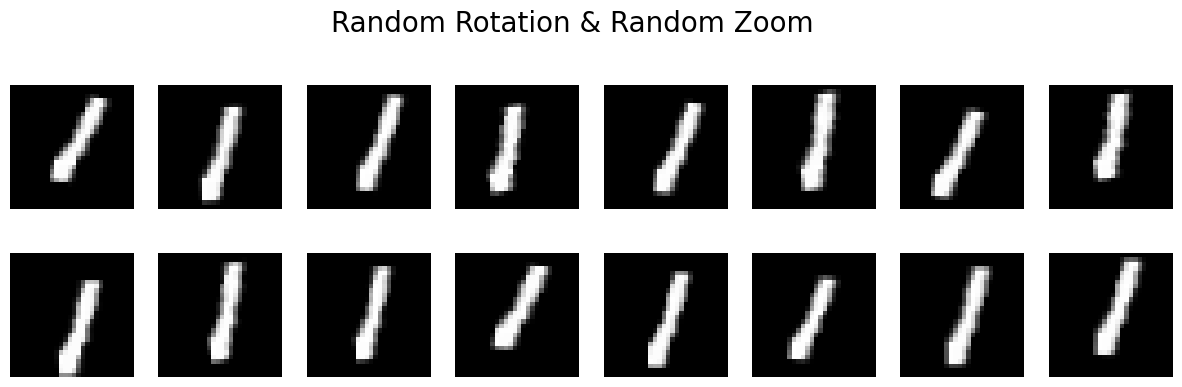

In [ ]:
# 3. 데이터 증강
from keras.preprocessing.image import ImageDataGenerator
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    fill_mode = 'nearest'
)

aug = datagen.flow(x_train[2].reshape(-1, 28, 28, 1))

# Plot using a for loop
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 8, figsize = (15, 4))
plt.suptitle('Random Rotation & Random Zoom', fontsize=20, y=1.05)
axes = axes.ravel()

for i in range(16):

    aug_img = next(aug)[0]
    axes[i].imshow(aug_img, cmap = 'gray')
    axes[i].axis('off')

plt.show()

# 모델 정의

In [ ]:
from tensorflow.keras import layers, models, regularizers, optimizers, callbacks, metrics
from tensorflow.keras.callbacks import ReduceLROnPlateau
def create_model(
    num_hidden_layers=3,
    hidden_units=1024,
    dropout_rate=0.0,
    l2_regularizer=0.01,
    momentum=0.9,
    reduce_lr_factor=0.2,
    reduce_lr_patience=4,
    initial_learning_rate=0.01,
):
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28, 1)))

    for _ in range(num_hidden_layers):
        model.add(layers.Dense(hidden_units, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(l2_regularizer)))
        model.add(layers.BatchNormalization())  # 활성화 함수 이전에 배치 정규화 적용
        model.add(layers.Activation('relu'))  # 활성화 함수 분리
        model.add(layers.Dropout(dropout_rate))


    model.add(layers.Dense(10, activation='softmax'))

    optimizer=optimizers.SGD(momentum=momentum, learning_rate = initial_learning_rate)
    reduce_lr = ReduceLROnPlateau(
        monitor='val_categorical_accuracy',
        factor=reduce_lr_factor,
        patience=reduce_lr_patience,
        verbose=1
    )

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy']
    )
    return model, reduce_lr


# 훈련 로그 저장소 초기화
Google 드라이브 저장소에 훈련 로그를 저장하기 위한 폴더를 생성합니다.
폴더가 이미 있다면 내용을 지웁니다.

In [ ]:
import os
from google.colab import drive

# Google Drive 마운트
drive.mount('/content/drive')
SAVE_DIR = '/content/drive/My Drive/HW3_results'  # 저장할 경로 설정

def reset_model_storage(save_dir=SAVE_DIR):
    if os.path.exists(save_dir):
        # 디렉토리 내 모든 파일 삭제
        for filename in os.listdir(save_dir):
            file_path = os.path.join(save_dir, filename)
            try:
                if os.path.isfile(file_path):
                    os.unlink(file_path)  # 파일 삭제
                elif os.path.isdir(file_path):
                    os.rmdir(file_path)  # 디렉토리 삭제 (비어 있을 경우)
            except Exception as e:
                print(f'Error deleting {file_path}: {e}')
        print(f"모델 저장소 {save_dir}가 초기화되었습니다.")
    else:
        print(f"{save_dir} 디렉토리가 존재하지 않습니다.")

# 모델 저장소 초기화 함수 실행
reset_model_storage()

Mounted at /content/drive
모델 저장소 /content/drive/My Drive/bohb_results가 초기화되었습니다.


# 학습 정의 및 하이퍼 파라미터 범위 정의



In [ ]:
import hpbandster.core.nameserver as hpns
import hpbandster.core.result as hpres

from hpbandster.optimizers import BOHB


import ConfigSpace as CS
from tensorflow.keras.callbacks import EarlyStopping
from hpbandster.core.worker import Worker

class MyWorker(Worker):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def compute(self, config, budget, *args, **kwargs):
        print("Hyperparameters:", config)  # 현재 하이퍼파라미터 출력

        num_hidden_layers = config['num_hidden_layers']
        hidden_units = 2 ** config['hidden_units_exp']  # 2의 거듭제곱으로 변환
        dropout_rate = config['dropout_rate']
        l2_regularizer = config['l2_regularizer']
        momentum = config['momentum']
        reduce_lr_factor = config['reduce_lr_factor']
        reduce_lr_patience = config['reduce_lr_patience']
        initial_learning_rate = config['initial_learning_rate']  # 'initial_learning_rate

        model, reduce_lr = create_model(
            num_hidden_layers,
            hidden_units,
            dropout_rate,
            l2_regularizer,
            momentum,
            reduce_lr_factor,
            reduce_lr_patience,
            initial_learning_rate,
        )

        # EarlyStopping 콜백 정의
        early_stopping = EarlyStopping(
            monitor='val_categorical_accuracy',  # 검증 손실 기반으로 모니터링
            patience=8,           # 8 에폭 동안 성능 향상이 없으면 학습 조기 종료
            restore_best_weights=True  # 최적의 가중치로 복원
        )

        model.fit(
            datagen.flow(x_train.reshape(-1, 28, 28, 1), y_train, batch_size=128),  # 데이터 증강 적용
            epochs=int(budget),
            verbose=1,
            validation_data=(x_val.reshape(-1, 28, 28, 1), y_val),
            callbacks=[reduce_lr, early_stopping],
        )

        loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
        return {'loss': -accuracy, 'info': {'test_accuracy': accuracy}}

def get_configspace():
    cs = CS.ConfigurationSpace()
    cs.add_hyperparameters([
        CS.UniformIntegerHyperparameter('num_hidden_layers', lower=1, upper=5, default_value=3),
        CS.UniformIntegerHyperparameter(
            'hidden_units_exp',
            lower=7,
            upper=10,
            default_value=10
        ), CS.UniformFloatHyperparameter('dropout_rate', lower=0.0, upper=0.5, default_value=0.1),
        CS.UniformFloatHyperparameter('l2_regularizer', lower=1e-4, upper=1e-0, log=True, default_value=1e-2),
        CS.UniformFloatHyperparameter('momentum', lower=0.0, upper=1.0, default_value=0.9),
        CS.UniformFloatHyperparameter('reduce_lr_factor', lower=0.05, upper=0.9, default_value=0.2),
        CS.UniformIntegerHyperparameter('reduce_lr_patience', lower=2, upper=6, default_value=4),
        CS.UniformFloatHyperparameter('initial_learning_rate', lower=1e-5, upper=1e-1, log=True, default_value=1e-2)
    ])
    return cs



# 구글 드라이브 설정

In [ ]:
import os
import json
import time
from google.colab import drive
# Google Drive 마운트
drive.mount('/content/drive')
SAVE_DIR = '/content/drive/My Drive/HW3_results'  # 저장할 경로 설정

# 결과 저장 폴더 생성 (없을 경우)
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
prev run DNE


# 학습 실행

- 매 iteration 마다 실행 내역이 google drive에 저장되므로, 실행 중간에 종료하더라도 마지막 iteration 내용 까지 파일로 저장됩니다.
- 아래 반복문의 회수를 수정하면 실행 epoch 수를 수정할 수 있습니다.
      # BOHB 실행 및 결과 저장
      for i in range(100): # <-- 여기를 수정하면 epoch 수를 수정할 수 있습니다.
        result = bohb.run(n_iterations=1)
        print("current iter: ", result.num_iterations())
        # iteration 종료 시 결과 저장
        # 결과 저장
        with open(os.path.join(SAVE_DIR, 'results.pkl'), 'wb') as fh:
            pickle.dump(result, fh)

# ❗주의❗
- 한 번 실행 중간에 종료하면 워커가 계속 남아있는 문제가 있으나 해결하지 못했습니다.
- 만약 **비정상적인 출력이 확인**되면(이전에 실행되던 진행 로그가 계속 출력되는 문제) **런타임 초기화 후 처음부터 다시 실행**해주세요.
- 통계 분석을 위한 로그 파일을 저장하기 위해서는 최소한 1 epoch가 실행 완료되어야 합니다.

In [ ]:
import os
import pickle
import hpbandster.core.result as hpres
from hpbandster.core.result import json_result_logger

result_logger = hpres.json_result_logger(directory=SAVE_DIR, overwrite=True)

# 네임 서버와 워커를 새로 시작하는 함수
def start_new_ns_and_workers():
    global NS, w
    NS = hpns.NameServer(run_id='bohb', host='127.0.0.1', port=9090)  # 포트를 명시적으로 설정
    NS.start()
    w = MyWorker(nameserver='127.0.0.1', nameserver_port=9090, run_id='bohb')  # 동일한 포트로 설정
    w.run(background=True)
    time.sleep(2)  # 잠시 대기하여 워커가 네임 서버에 연결될 시간을 줍니다.

start_new_ns_and_workers()

# BOHB 설정
try:
    bohb = BOHB(
        configspace=get_configspace(),
        run_id='bohb',
        nameserver='127.0.0.1',
        min_budget=3,
        max_budget=50,
        result_logger=result_logger,  # 결과 로거 설정
    )

    # BOHB 실행 및 결과 저장
    for i in range(100): # <-- 여기를 수정하면 epoch 수를 수정할 수 있습니다.
        result = bohb.run(n_iterations=1)
        print("current iter: ", result.num_iterations())
        # iteration 종료 시 결과 저장
        # 결과 저장
        with open(os.path.join(SAVE_DIR, 'results.pkl'), 'wb') as fh:
            pickle.dump(result, fh)
except KeyboardInterrupt:
    print("\n작업이 중단되었습니다. 마지막 Iteration까지 결과가 저장되었습니다.")
finally:
    bohb.shutdown(shutdown_workers=True)
    NS.shutdown()

Streaming output truncated to the last 5000 lines.
375/375 [==============================] - 13s 34ms/step - loss: 0.8670 - categorical_accuracy: 0.8996 - val_loss: 0.7461 - val_categorical_accuracy: 0.9324 - lr: 0.0554
Epoch 5/50
375/375 [==============================] - 13s 33ms/step - loss: 0.8268 - categorical_accuracy: 0.9046 - val_loss: 0.7088 - val_categorical_accuracy: 0.9369 - lr: 0.0554
Epoch 6/50
375/375 [==============================] - 13s 34ms/step - loss: 0.8158 - categorical_accuracy: 0.9028 - val_loss: 0.7688 - val_categorical_accuracy: 0.9222 - lr: 0.0554
Epoch 7/50
375/375 [==============================] - 13s 35ms/step - loss: 0.8102 - categorical_accuracy: 0.9050 - val_loss: 0.7476 - val_categorical_accuracy: 0.9238 - lr: 0.0554
Epoch 8/50
375/375 [==============================] - 13s 34ms/step - loss: 0.8134 - categorical_accuracy: 0.9065 - val_loss: 0.8187 - val_categorical_accuracy: 0.9027 - lr: 0.0554
Epoch 9/50
375/375 [==============================] - 1

# 정확도 그래프

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


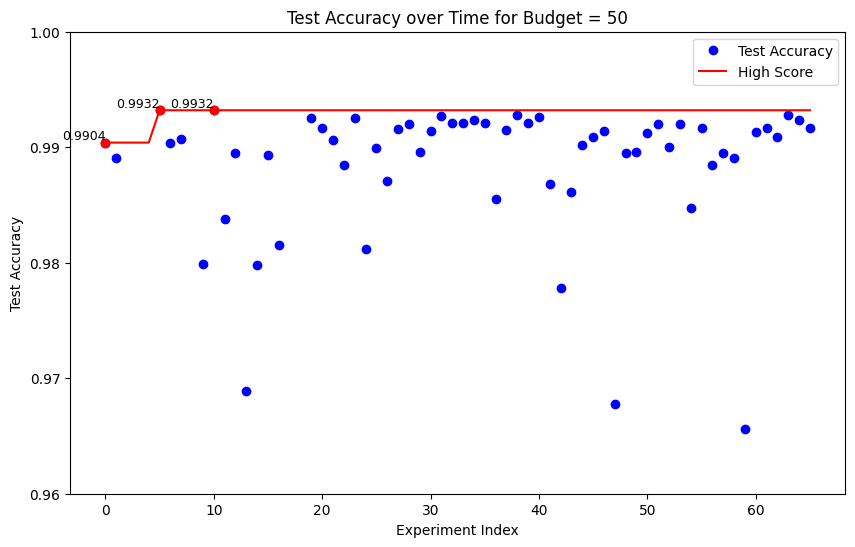

In [ ]:
import json
import pickle
import matplotlib.pyplot as plt
import os
from google.colab import drive

# Google Drive 마운트
drive.mount('/content/drive')
SAVE_DIR = '/content/drive/My Drive/HW3_results'  # 저장할 경로 설정
# 저장된 결과 파일 경로
result_file = os.path.join(SAVE_DIR, 'results.pkl')

# 결과 불러오기
with open(result_file, 'rb') as f:
    result = pickle.load(f)

# get all executed runs
all_runs = result.get_all_runs()

# get the 'dict' that translates config ids to the actual configurations
id2conf = result.get_id2config_mapping()

# budget = 50인 실험 결과 추출
budget_50_results = []
for entry in all_runs:
    budget = entry['budget']
    if budget == 50.0:
        test_accuracy = entry['info']['test_accuracy']
        budget_50_results.append(test_accuracy)

# 실험 인덱스 생성
indices = range(len(budget_50_results))

# 최고 테스트 정확도 값 추적
max_accuracy = []
current_max = 0
for accuracy in budget_50_results:
    if accuracy > current_max:
        current_max = accuracy
    max_accuracy.append(current_max)

# 테스트 정확도 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(indices, budget_50_results, 'bo', label='Test Accuracy')

# 최고 기록 점 표시
for i, (x, y) in enumerate(zip(indices, budget_50_results)):
    if y == max_accuracy[i]:
        plt.plot(x, y, 'ro')
        plt.text(x, y, f'{y:.4f}', fontsize=9, verticalalignment='bottom', horizontalalignment='right')

# 최고 기록을 잇는 선 그리기
plt.plot(indices, max_accuracy, 'r-', label='High Score')

# 세밀한 y축 범위 설정
plt.ylim(0.96, 1.0)
plt.yticks([0.96, 0.97, 0.98, 0.99, 1.0])

# 그래프 라벨 및 제목 추가
plt.xlabel('Experiment Index')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy over Time for Budget = 50')
plt.legend()
plt.show()


# 파라미터별 정확도 분포

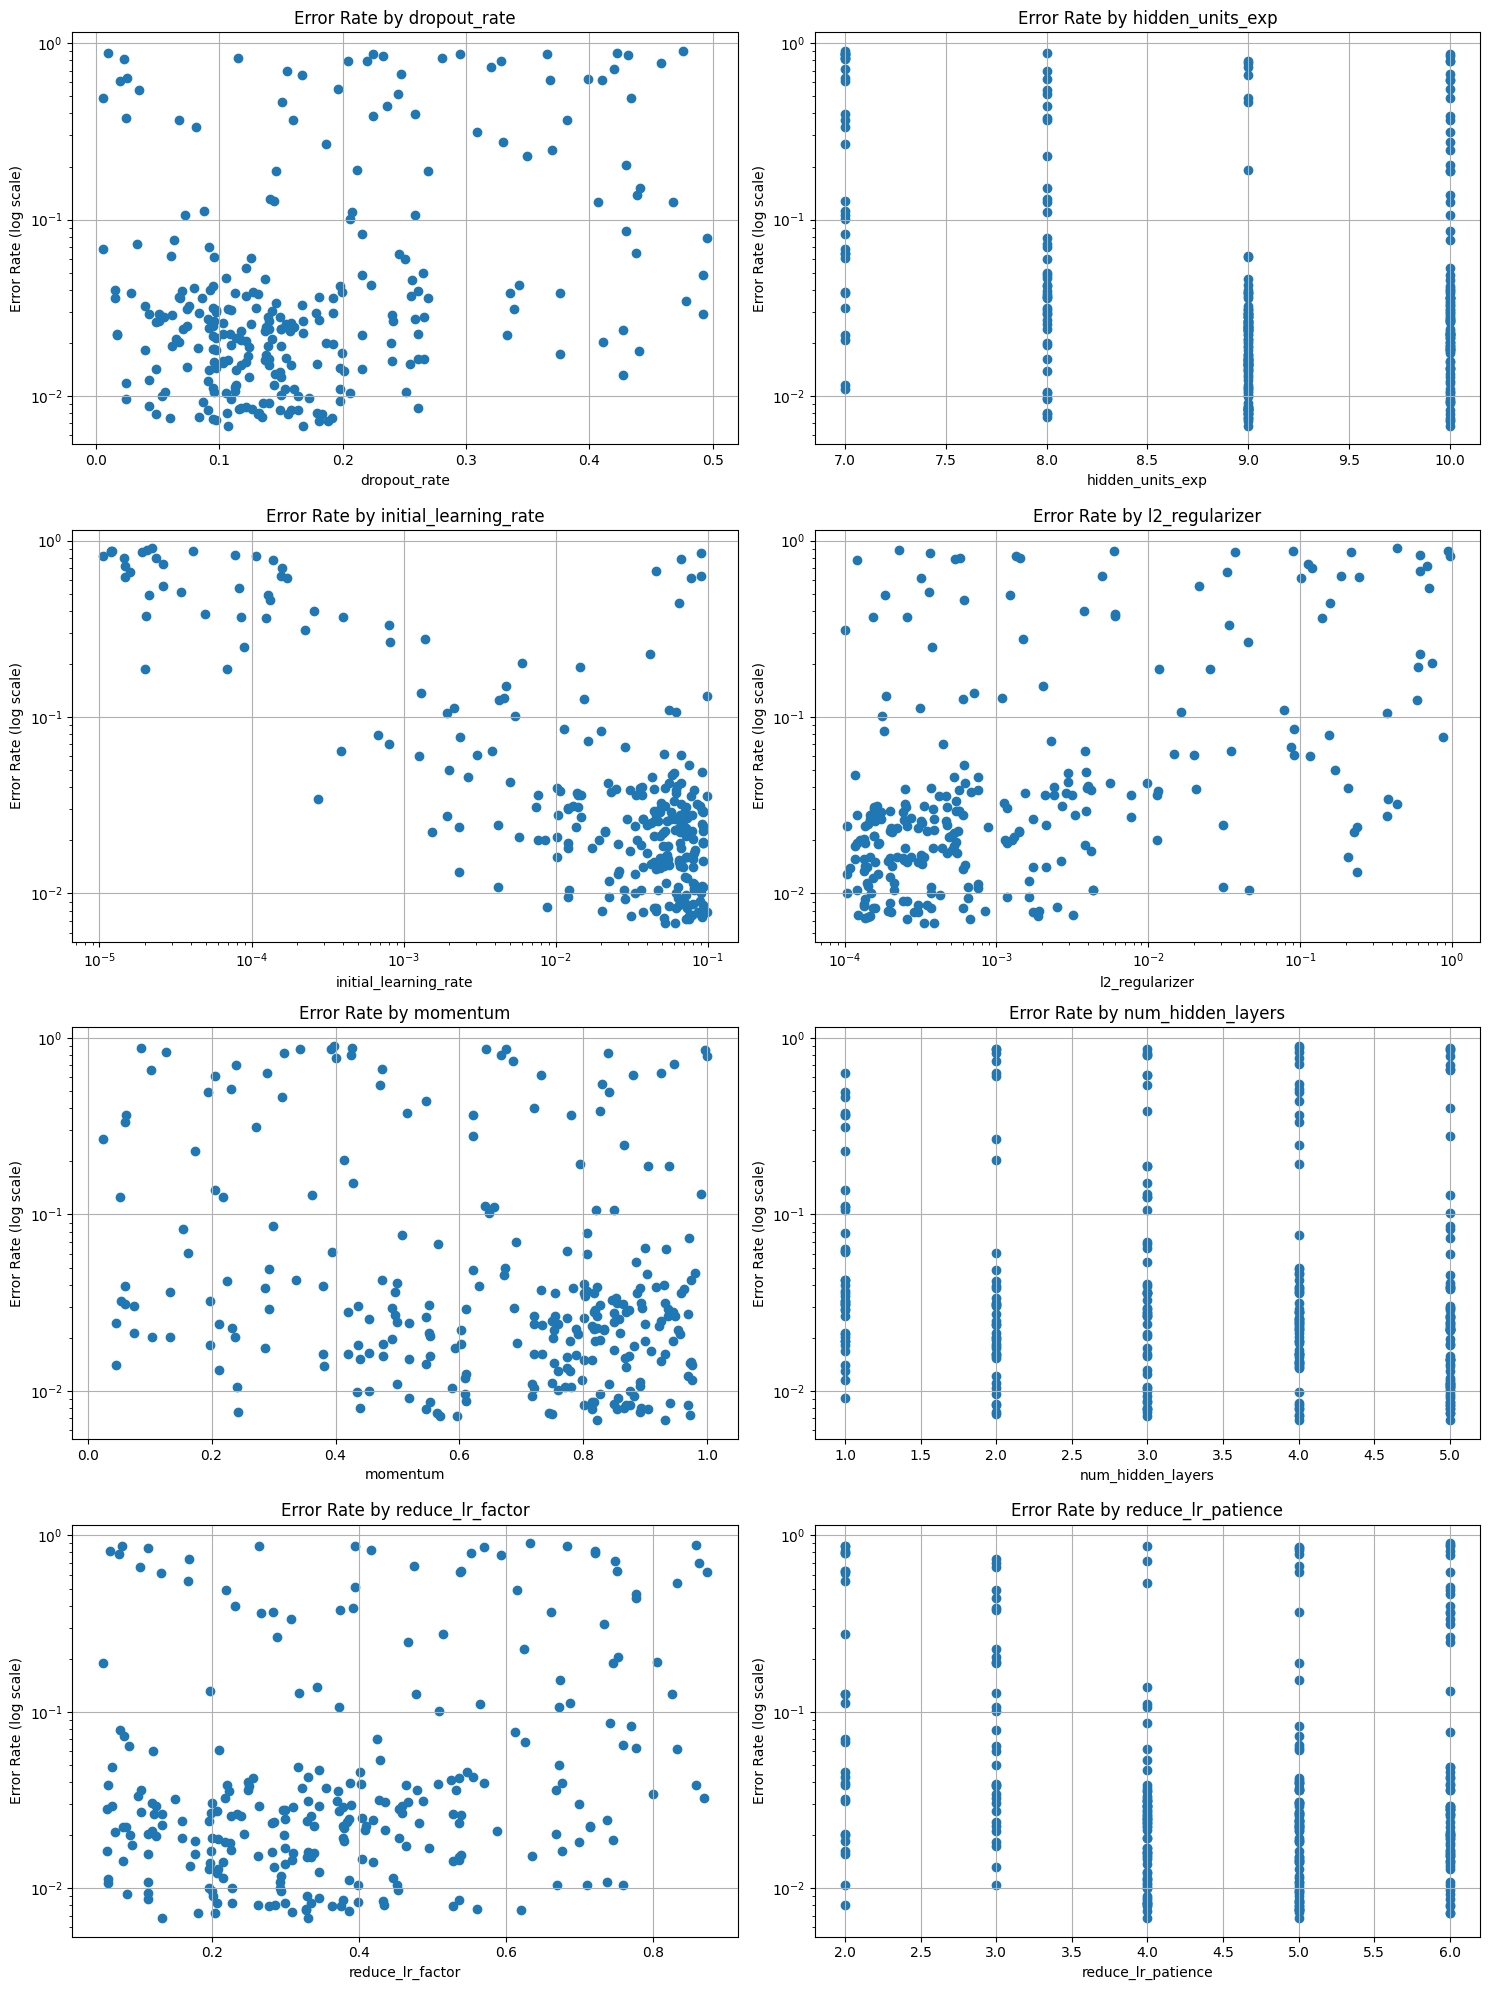

In [ ]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

# Google Drive 마운트
drive.mount('/content/drive')
# 저장된 결과 파일 경로
result_file = '/content/drive/My Drive/HW3_results/results.pkl'

# 결과 불러오기
with open(result_file, 'rb') as f:
    result = pickle.load(f)

# 모든 실행된 실험 가져오기
all_runs = result.get_all_runs()

# config id를 실제 구성으로 변환하는 'dict' 가져오기
id2conf = result.get_id2config_mapping()

# 하이퍼파라미터와 정확도 추출
data = []
for run in all_runs:
    config_id = run['config_id']
    config = id2conf[config_id]['config']
    test_accuracy = run['info']['test_accuracy']
    data.append({**config, 'test_accuracy': test_accuracy})

# DataFrame으로 변환
df = pd.DataFrame(data)

# 에러율 계산
df['error_rate'] = 1 - df['test_accuracy']

# 각 하이퍼파라미터별 에러율 분포도 그리기
fig, axes = plt.subplots(4, 2, figsize=(15, 20))
axes = axes.flatten()

for i, param in enumerate(df.columns[:-2]):  # 'test_accuracy'와 'error_rate' 제외
    axes[i].scatter(df[param], df['error_rate'])
    axes[i].set_title(f'Error Rate by {param}')
    axes[i].set_xlabel(param)
    axes[i].set_ylabel('Error Rate (log scale)')
    axes[i].set_yscale('log')
    if param in ['initial_learning_rate', 'l2_regularizer']:
        axes[i].set_xscale('log')
    axes[i].grid(True)

# 여분의 서브플롯 숨기기
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


# 쌍변량 산점도

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-7-57560bd15c18>:55: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), orientation='horizontal', label='Test Accuracy')


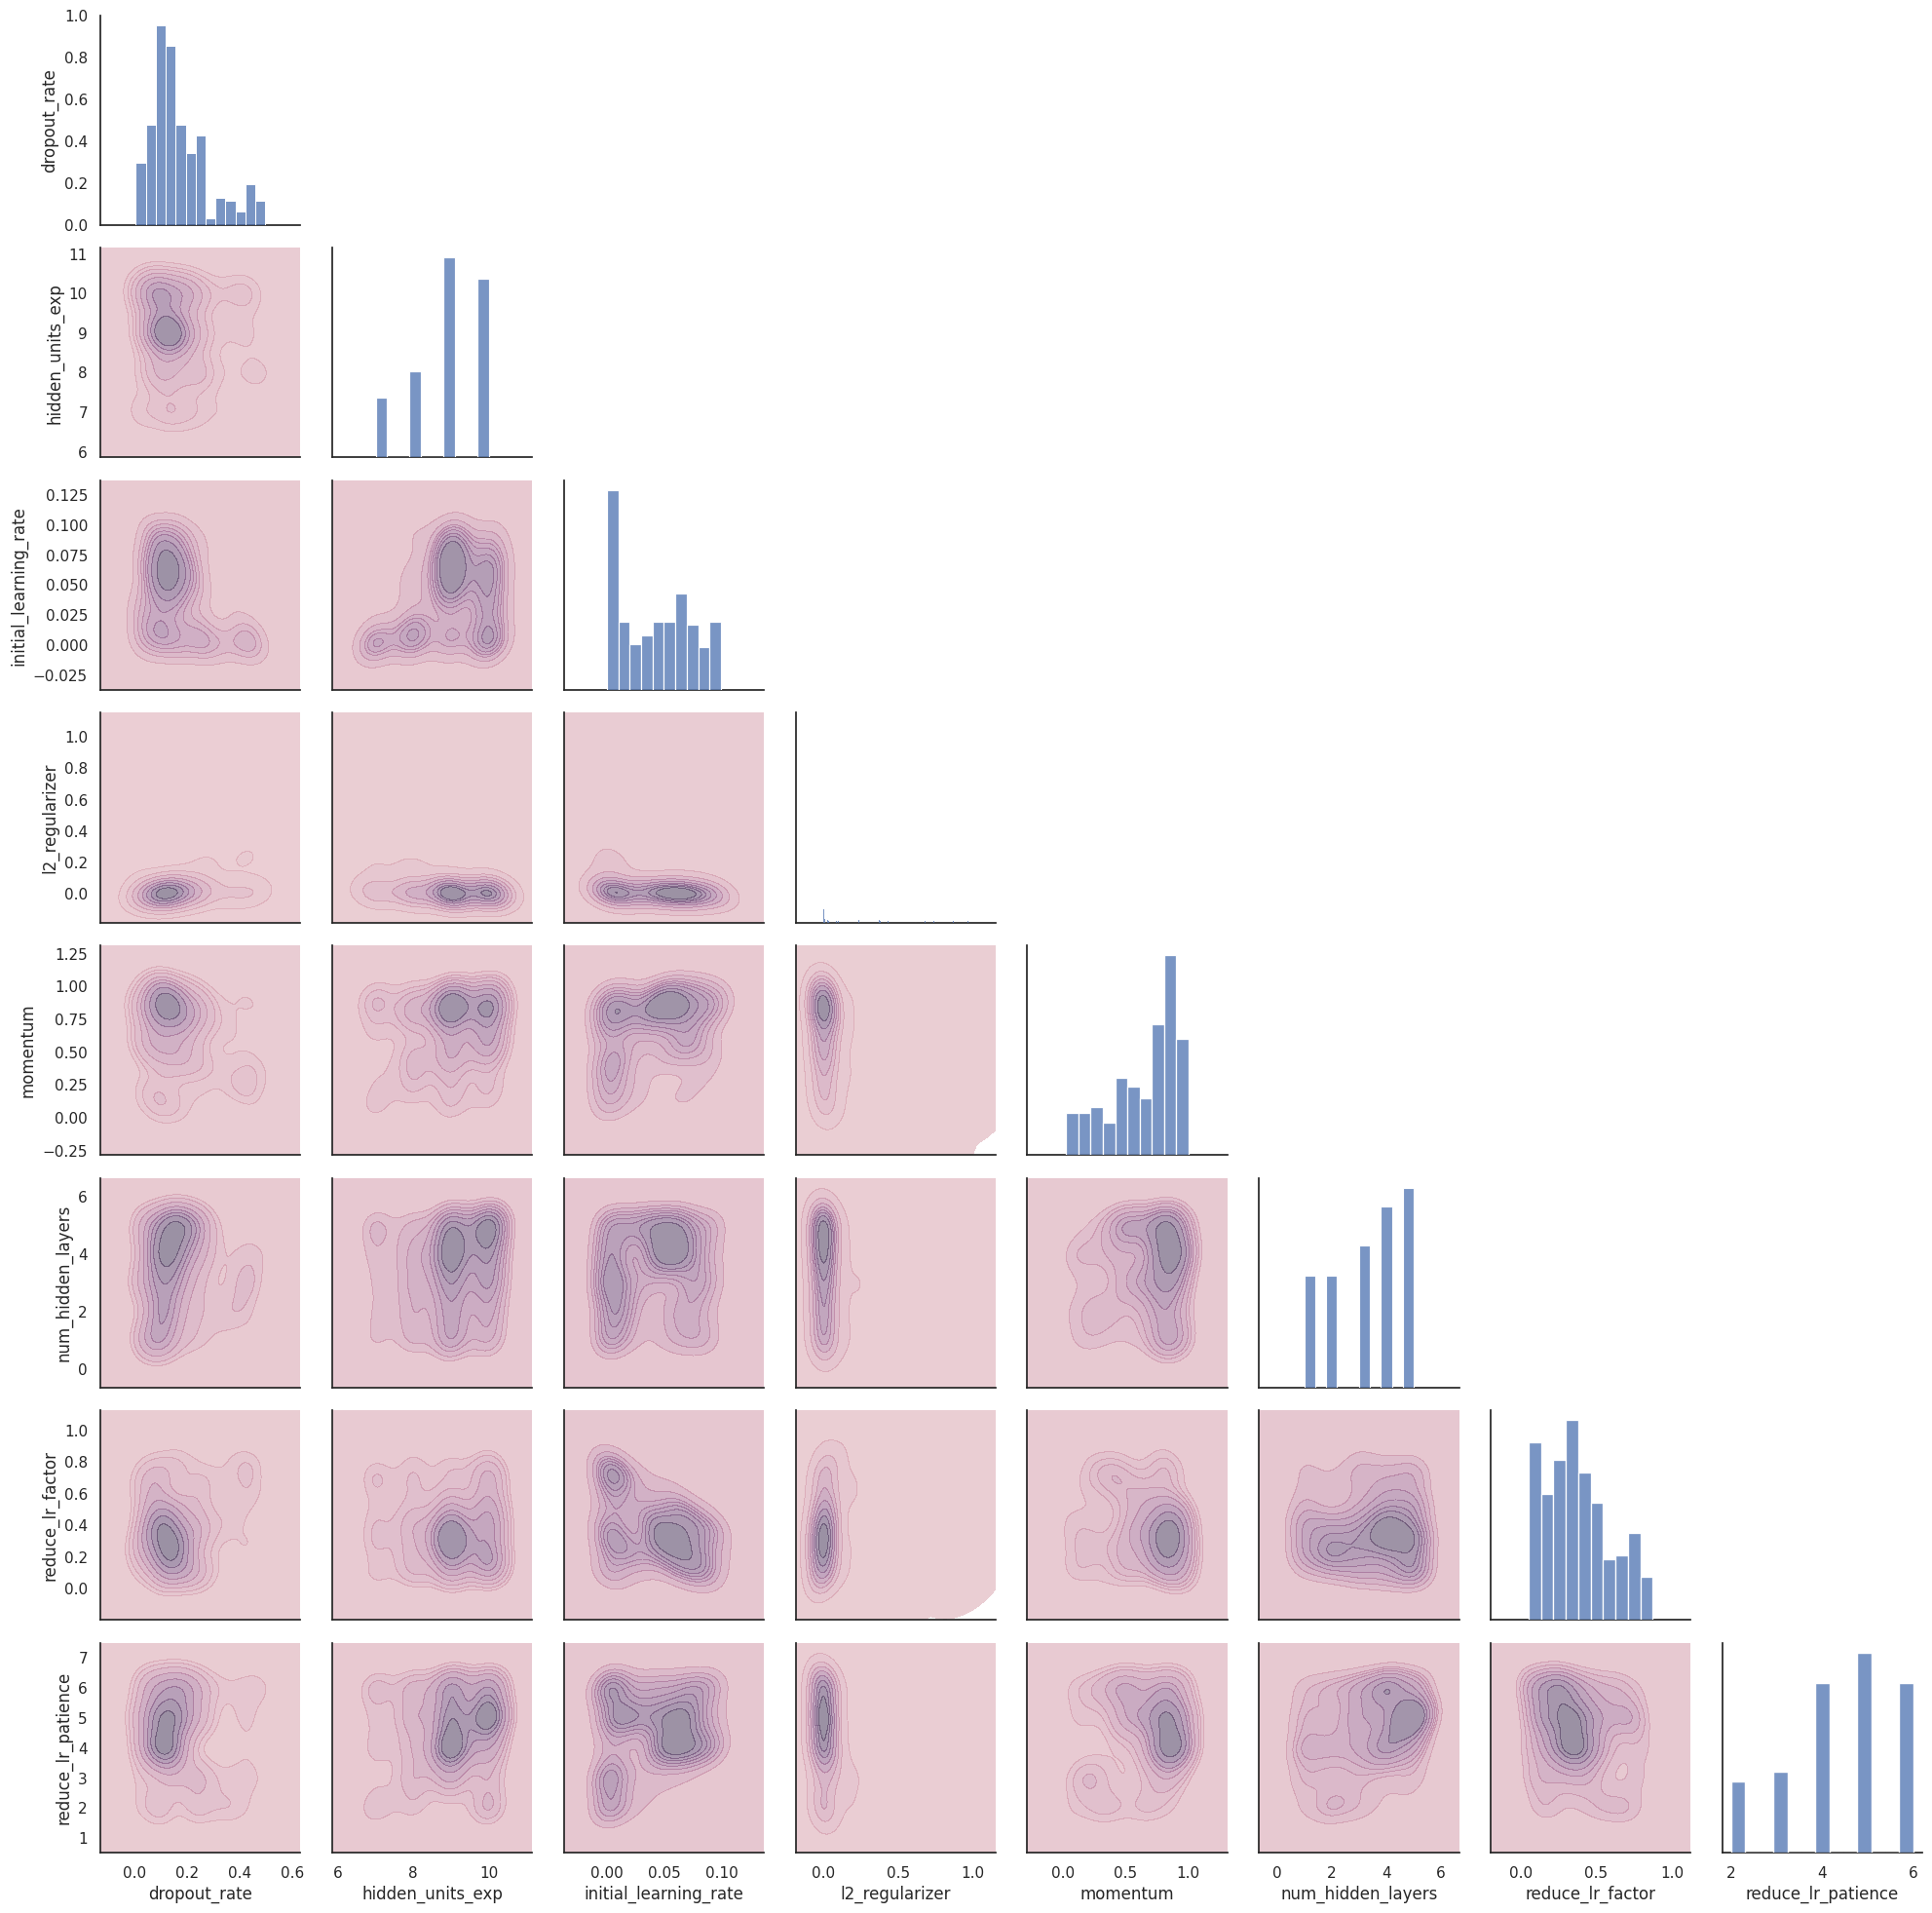

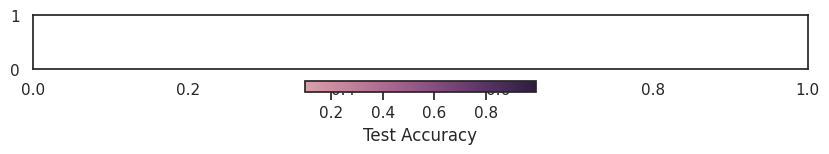

In [ ]:

import os
from google.colab import drive

# Google Drive 마운트
drive.mount('/content/drive')
# 저장된 결과 파일 경로
result_file = '/content/drive/My Drive/HW3_results/results.pkl'

import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 결과 불러오기
with open(result_file, 'rb') as f:
    result = pickle.load(f)

# 모든 실행된 실험 가져오기
all_runs = result.get_all_runs()

# config id를 실제 구성으로 변환하는 'dict' 가져오기
id2conf = result.get_id2config_mapping()

# 하이퍼파라미터와 정확도 추출
data = []
for run in all_runs:
    config_id = run['config_id']
    config = id2conf[config_id]['config']
    test_accuracy = run['info']['test_accuracy']
    data.append({**config, 'test_accuracy': test_accuracy})

# DataFrame으로 변환
df = pd.DataFrame(data)

# 하이퍼파라미터 쌍변량 산점도 그래프 그리기
sns.set(style="white")
cmap = sns.cubehelix_palette(as_cmap=True, light=0.7)

# Pairplot 설정
g = sns.PairGrid(df, vars=df.columns[:-1], diag_sharey=False)
g.map_lower(sns.kdeplot, cmap=cmap, fill=True, alpha=0.5, thresh=0)
g.map_diag(sns.histplot, kde=False)

# 위쪽 삼각형 숨기기
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)

# 컬러바 추가
plt.figure(figsize=(10, 1))
norm = plt.Normalize(df['test_accuracy'].min(), df['test_accuracy'].max())
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), orientation='horizontal', label='Test Accuracy')
plt.show()
